# Homework07

Exercises to practice pandas, data analysis and regression

## Goals

- Understand the effects of pre-processing data
- Get familiar with the ML flow: encode -> normalize -> train -> evaluate
- Understand the difference between regression and classification tasks
- Build intuition for different regression models

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/data_utils.py

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor

from data_utils import object_from_json_url
from data_utils import regression_error

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02).

This is the dataset that has anthropometric information about U.S. Army personnel.

#### WARNING

Like we mentioned in class, this dataset is being used for these exercises due to the level of detail in the dataset and the rigorous process that was used in collecting the data.

This is a very specific dataset and should not be used to draw general conclusions about people, bodies, or anything else that is not related to the distribution of physical features of U.S. Army personnel.

In [3]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025F-A/5020-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

#### Nested data

This is that *nested* dataset from Week 02.

# 🤔

Let's load it into a `DataFrame` to see what happens.

In [4]:
# Read into DataFrame
ansur_df = pd.DataFrame.from_records(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear,foot,hand,head
0,18,F,66,135,1699,1645,"{'breadth': 30, 'length': 61, 'protrusion': 20}","{'breadth': 97, 'length': 243}","{'breadth': 78, 'length': 182, 'palm': 108}","{'height': 243, 'circumference': 557}"
1,30,M,68,207,1749,1715,"{'breadth': 35, 'length': 63, 'protrusion': 17}","{'breadth': 100, 'length': 252}","{'breadth': 87, 'length': 184, 'palm': 114}","{'height': 238, 'circumference': 560}"
2,27,M,67,121,1684,1657,"{'breadth': 36, 'length': 59, 'protrusion': 24}","{'breadth': 92, 'length': 251}","{'breadth': 84, 'length': 180, 'palm': 103}","{'height': 239, 'circumference': 516}"
3,20,M,73,185,1878,1828,"{'breadth': 36, 'length': 60, 'protrusion': 21}","{'breadth': 104, 'length': 280}","{'breadth': 95, 'length': 201, 'palm': 124}","{'height': 270, 'circumference': 582}"
4,33,M,76,150,1977,1883,"{'breadth': 39, 'length': 65, 'protrusion': 27}","{'breadth': 101, 'length': 271}","{'breadth': 90, 'length': 194, 'palm': 113}","{'height': 254, 'circumference': 559}"



# 😓🙄

That didn't work too well. We ended up with objects in our columns.

Luckily, our `DataFrame` library has a function called [`json_normalize()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) that can help.

In [5]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


Much better. `DataFrames` are magic.

#### Data Exploration

Before we start creating models, let's do a little bit of data analysis and get a feeling for the shapes, distributions and relationships of our data.

1. Print `min`, `max` and `average` values for all of the features.
2. Print `covariance` tables for `age`, `ear.length` and `head.circumference`.
3. Plot `age`, `ear.length` and `head.circumference` versus the $1$ *feature* that is most correlated to each of them.

Don't forget to *encode* and *normalize* the data.

Min:
 age                     17.0
gender                   0.0
height                  56.0
weight                   0.0
span                  1323.0
stature               1409.0
ear.breadth             25.0
ear.length              46.0
ear.protrusion          13.0
foot.breadth            77.0
foot.length            198.0
hand.breadth            67.0
hand.length            145.0
hand.palm               88.0
head.height            206.0
head.circumference     502.0
dtype: float64

Max:
 age                     58.0
gender                   1.0
height                  94.0
weight                 321.0
span                  2121.0
stature               1993.0
ear.breadth             46.0
ear.length              81.0
ear.protrusion          34.0
foot.breadth           126.0
foot.length            323.0
hand.breadth           105.0
hand.length            239.0
hand.palm              140.0
head.height            295.0
head.circumference     635.0
dtype: float64

Avg:
 age                   

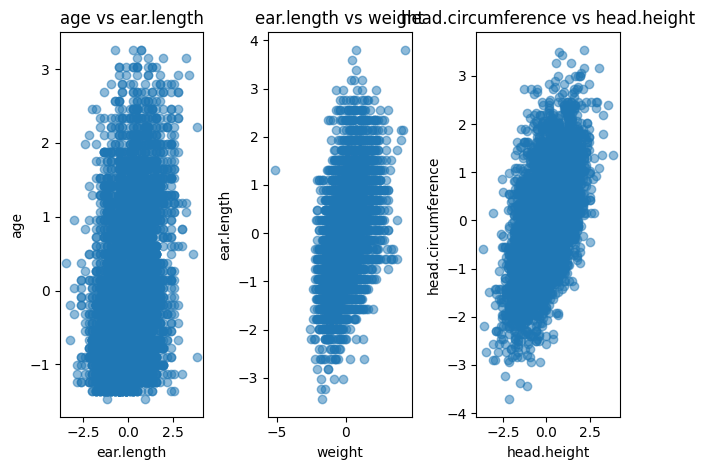

In [7]:

# Encode non-numerical features
obj_cols = ansur_df.select_dtypes(include='object').columns
ansur_df[obj_cols] = OrdinalEncoder().fit_transform(ansur_df[obj_cols])

# Print min, max, avg
print("Min:\n", ansur_df.min())
print("\nMax:\n", ansur_df.max())
print("\nAvg:\n", ansur_df.mean())

# Normalize data
scaled_df = pd.DataFrame(StandardScaler().fit_transform(ansur_df), columns=ansur_df.columns)

# Covariance for age, ear.length, head.circumference
print("\nCovariance:\n", scaled_df[['age','ear.length','head.circumference']].cov())

# Find features most correlated
corr = scaled_df.corr()
targets = ['age','ear.length','head.circumference']
most_corr = {t: corr[t].drop(t).idxmax() for t in targets}
print("\nMost correlated features:", most_corr)

# Plot
for i, t in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(scaled_df[most_corr[t]], scaled_df[t], alpha=0.5)
    plt.xlabel(most_corr[t])
    plt.ylabel(t)
    plt.title(f'{t} vs {most_corr[t]}')

plt.tight_layout()
plt.show()


### Interpretation

<span style="color:hotpink;">
Does anything stand out about these graphs? Or the correlations?<br>
Are correlations symmetric? Does the feature most correlated to ear length also have ear length as its most correlated pair?
</span>

<span style="color:hotpink;">
Interpretation and Correlations

What stands out about these graphs?

The graphs show different levels of correlation between features:

head.circumference vs head.height shows a very strong positive correlation, meaning as head height increases, head circumference also increases closely.

ear.length vs weight has a moderate positive correlation. There is a clear trend, but the points are more spread out.

age vs ear.length shows a weak correlation. The points are scattered and the relationship is not very clear.

Are correlations symmetric?
Yes, correlations are always symmetric. The correlation between feature A and feature B is the same as the correlation between B and A.

Does the feature most correlated to ear length also have ear length as its most correlated pair?
Not necessarily. Ear length is most strongly correlated with weight in this case, but weight might be even more strongly correlated with another feature, like head circumference. So, ear length is not necessarily the top correlation for weight.
</span>

### Regression

Now, we want to create a regression model to predict `head.circumference` from the data.

From our [Week 07](https://github.com/PSAM-5020-2025F-A/WK07) notebook, we can create a regression model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (done! ⚡️)
3. Normalize the data (done! 🍾)
4. Separate the outcome variable and the input features
5. Create a regression model using all features
6. Run model on training data and measure error
7. Plot predictions and interpret results
8. Run model on test data, measure error, plot predictions, interpret results

In [ ]:
# Work on Regression Model here

## Separate outcome variable and input features

## Create a regression model

## Measure error on training data

## Plot predictions and interpret results

In [ ]:
## Load Test Data
ANSUR_TEST_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025F-A/5020-utils/main/datasets/json/ansur-test.json"

ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)
ansur_test_df = pd.json_normalize(ansur_test_data)

ansur_test_encoded_df = ansur_test_df.copy()

g_vals = ansur_encoder.transform(ansur_test_df[["gender"]].values)
ansur_test_encoded_df[["gender"]] = g_vals

ansur_test_scaled_df = ansur_scaler.transform(ansur_test_encoded_df)

In [ ]:
## Run model on test data

## Measure error on test data

## Plot predictions and interpret results

### Interpretation

<span style="color:hotpink;">
How well does your model perform?<br>
How could you improve it?<br>
Are there ranges of circumferences that don't get predicted well?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>